# properties of each water mass and how they vary

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec

# for anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
def organize(s_t, do_no3, ta_dic, region, final=True):
    # make dictionary of transport and tracer concentrations of each water parcel within a specified region
    
    # the region is based on the boolean input into the function defined here
    # region options are salish, cuc, offshore deep, offshore surface, north, south, fresh, loop
    mydata= s_t
    # boundary definitions
    bdy_loo = 0
    bdy_sou = 2
    bdy_off = 3
    bdy_nor = 4
    saltdiv = 32
    sdiv = 33.5
    if region == 'salish':
        boolean = ((abs(mydata.init_t-mydata.final_t) > 24) & ~np.isnan(mydata.final_section))
    elif region == 'cuc':
        boolean = (mydata.final_section==bdy_sou) & (mydata.final_salt >= sdiv)
    elif region == 'offshore deep':
        boolean = (mydata.final_section==bdy_off) & (mydata.final_depth > 120)
    elif region == 'offshore surface':
        boolean = (mydata.final_section==bdy_off) & (mydata.final_depth <=120)
    elif region == 'north':
        boolean = (mydata.final_section==bdy_nor)
    elif region == 'south':
        boolean = (mydata.final_section==bdy_sou) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)
    elif region == 'fresh':
        boolean = ((mydata.final_section==bdy_sou) & (mydata.final_salt < saltdiv))
    elif region == 'loop':
        boolean = (mydata.final_section==bdy_loo) & (abs(mydata.init_t-mydata.final_t) > 24)
    else:
        print('not in the list of regions, options are: salish, cuc, offshore deep, offshore surface, north, south, fresh, loop')
    


    if final==True: # ie. looking at the water parcels at the outer boundaries
        # get data
        transport = mydata.init_transp[boolean].values
        salt = mydata.init_salt[boolean].values
        temp = mydata.init_temp[boolean].values
        mydata = do_no3
        NO3 = mydata.init_salt[boolean].values
        DO = mydata.init_temp[boolean].values
        mydata = ta_dic
        DIC = mydata.init_salt[boolean].values
        TA = mydata.init_temp[boolean].values
    else: # ie. looking at the water parcels at the JdF boundary
        # get data
        transport = mydata.final_transp[boolean].values
        salt = mydata.final_salt[boolean].values
        temp = mydata.final_temp[boolean].values
        mydata = do_no3
        NO3 = mydata.final_salt[boolean].values
        DO = mydata.final_temp[boolean].values
        mydata = ta_dic
        DIC = mydata.final_salt[boolean].values
        TA = mydata.final_temp[boolean].values

    # set up dictionary
    d = {'transport':transport,'salt':salt,'temp':temp,'DO':DO,'NO3':NO3,'TA':TA,'DIC':DIC}
    df = pd.DataFrame(d)

    return df

## Properties into JdF

In [ ]:
region = 'salish'
final = False

up13 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20131024/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20131024/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20131024/ariane_positions_quantitative.nc'),
             region, final)

up14 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20140903/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20140903/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20140903/ariane_positions_quantitative.nc'),
             region, final)

up15 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20150905/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20150905/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20150905/ariane_positions_quantitative.nc'),
             region, final)

up16 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20160913/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20160913/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20160913/ariane_positions_quantitative.nc'),
             region, final)

up17 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20171012/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20171012/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20171012/ariane_positions_quantitative.nc'),
             region, final)

up18 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20180906/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20180906/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20180906/ariane_positions_quantitative.nc'),
             region, final)

up21 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20210922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20210922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20210922/ariane_positions_quantitative.nc'),
             region, final)

up22 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20221015/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20221015/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20221015/ariane_positions_quantitative.nc'),
             region, final)

In [6]:
dw13 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20140306/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20140306/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20140306/ariane_positions_quantitative.nc'),
             region, final)

dw15 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20160319/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20160319/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20160319/ariane_positions_quantitative.nc'),
             region, final)

dw16 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20170419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20170419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20170419/ariane_positions_quantitative.nc'),
             region, final)

dw17 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20180201/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20180201/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20180201/ariane_positions_quantitative.nc'),
             region, final)

dw19 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20200127/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20200127/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20200127/ariane_positions_quantitative.nc'),
             region, final)

dw20 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20210202/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20210202/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20210202/ariane_positions_quantitative.nc'),
             region, final)

dw21 = organize(xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20220125/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20220125/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20220125/ariane_positions_quantitative.nc'),
             region, final)

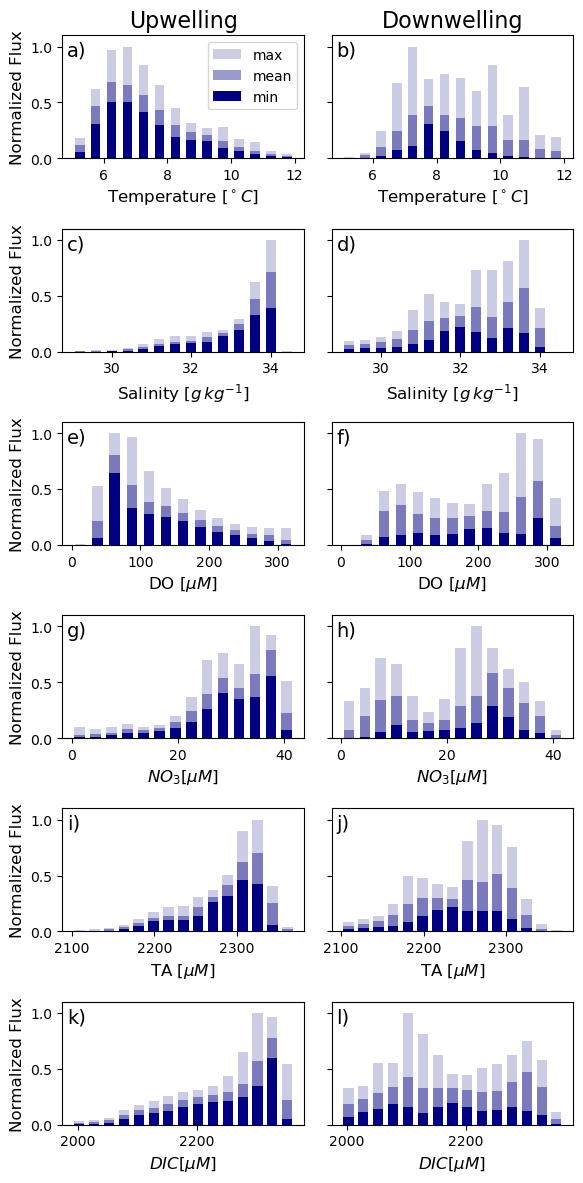

In [7]:
fig, ax = plt.subplots(6, 2, figsize = (6, 12))
plt.rcParams['font.size'] = 12

#TEMPERATURE
bins = np.arange(5,12.5,0.5)
#plt upwelling
h,x,_ = ax[0,0].hist([up13.temp,up14.temp,up15.temp,up16.temp,up17.temp,up18.temp,up21.temp,up22.temp], bins=bins,
                             weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up21.transport,up22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[0,0].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0,0].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0,0].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0,0].set_title('Upwelling', fontsize = 16)
ax[0,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[0,0].set_xlabel('Temperature [$^\circ C$]', fontsize = 12)
ax[0,0].set_ylim([0,1.1])
ax[0,0].legend(fontsize = 10)

#plt downwelling
h,x,_ = ax[0,1].hist([dw13.temp,dw15.temp,dw16.temp,dw17.temp,dw19.temp,dw20.temp,dw21.temp], bins=bins,
                             weights= [dw13.transport,dw15.transport,dw16.transport,dw17.transport,dw19.transport,dw20.transport,dw21.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[0,1].bar(bin_centers,maxi,width = 0.3,color='navy',alpha=0.2,label='max')
ax[0,1].bar(bin_centers,mean,width = 0.3, color='navy',alpha=0.4,label='mean')
ax[0,1].bar(bin_centers, mini,width = 0.3, color='navy',label='min')

ax[0,1].set_title('Downwelling', fontsize = 16)
ax[0,1].set_yticklabels([])
ax[0,1].set_xlabel('Temperature [$^\circ C$]', fontsize = 12)
ax[0,1].set_ylim([0,1.1])
# ax[1].legend(fontsize = 12)

#SALINITY
bins = np.arange(29,34.8,0.4)
#plt upwelling
h,x,_ = ax[1,0].hist([up13.salt,up14.salt,up15.salt,up16.salt,up17.salt,up18.salt,up21.salt,up22.salt], bins=bins, 
                           weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up21.transport,up22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[1,0].bar(bin_centers,maxi,width = 0.25,color='navy',alpha=0.2,label='max')
ax[1,0].bar(bin_centers,mean,width = 0.25, color='navy',alpha=0.4,label='mean')
ax[1,0].bar(bin_centers, mini,width = 0.25, color='navy',label='min')

# ax[0].set_title('Winter')
ax[1,0].set_ylabel('Normalized Flux', fontsize=12)
ax[1,0].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=12)
ax[1,0].set_ylim([0,1.1])

#plt downwelling
h,x,_ = ax[1,1].hist([dw13.salt,dw15.salt,dw16.salt,dw17.salt,dw19.salt,dw20.salt,dw21.salt], bins=bins, 
                           weights= [dw13.transport,dw15.transport,dw16.transport,dw17.transport,dw19.transport,dw20.transport,dw21.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[1,1].bar(bin_centers,maxi,width = 0.25,color='navy',alpha=0.2,label='max')
ax[1,1].bar(bin_centers,mean,width = 0.25, color='navy',alpha=0.4,label='mean')
ax[1,1].bar(bin_centers, mini,width = 0.25, color='navy',label='min')


ax[1,1].set_yticklabels([])#,fontsize=14)
ax[1,1].set_xlabel('Salinity [$g \, kg^{-1}$]', fontsize=12)
ax[1,1].set_ylim([0,1.1])

#DO
bins = np.arange(0,350,25)
#plt upwelling
h,x,_ = ax[2,0].hist([up13.DO,up14.DO,up15.DO,up16.DO,up17.DO,up18.DO,up21.DO,up22.DO], bins=bins,
                             weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up21.transport,up22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[2,0].bar(bin_centers,maxi,width = 15,color='navy',alpha=0.2,label='max')
ax[2,0].bar(bin_centers,mean,width = 15, color='navy',alpha=0.4,label='mean')
ax[2,0].bar(bin_centers, mini,width = 15, color='navy',label='min')

ax[2,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[2,0].set_xlabel('DO [$\mu M$]', fontsize = 12)
ax[2,0].set_ylim([0,1.1])
# ax[2,0].legend(fontsize = 10)

#plt downwelling
h,x,_ = ax[2,1].hist([dw13.DO,dw15.DO,dw16.DO,dw17.DO,dw19.DO,dw20.DO,dw21.DO], bins=bins,
                             weights= [dw13.transport,dw15.transport,dw16.transport,dw17.transport,dw19.transport,dw20.transport,dw21.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[2,1].bar(bin_centers,maxi,width = 15,color='navy',alpha=0.2,label='max')
ax[2,1].bar(bin_centers,mean,width = 15, color='navy',alpha=0.4,label='mean')
ax[2,1].bar(bin_centers, mini,width = 15, color='navy',label='min')

ax[2,1].set_yticklabels([])
ax[2,1].set_xlabel('DO [$\mu M$]', fontsize = 12)
ax[2,1].set_ylim([0,1.1])
# ax[1].legend(fontsize = 12)

#NO3
bins = np.arange(0,45,3)
#plt upwelling
h,x,_ = ax[3,0].hist([up13.NO3,up14.NO3,up15.NO3,up16.NO3,up17.NO3,up18.NO3,up21.NO3,up22.NO3], bins=bins, 
                           weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up21.transport,up22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[3,0].bar(bin_centers,maxi,width = 2,color='navy',alpha=0.2,label='max')
ax[3,0].bar(bin_centers,mean,width = 2, color='navy',alpha=0.4,label='mean')
ax[3,0].bar(bin_centers, mini,width = 2, color='navy',label='min')

# ax[0].set_title('Winter')
ax[3,0].set_ylabel('Normalized Flux', fontsize=12)
ax[3,0].set_xlabel('$NO_3 [\mu M$]', fontsize=12)
ax[3,0].set_ylim([0,1.1])

#plt downwelling
h,x,_ = ax[3,1].hist([dw13.NO3,dw15.NO3,dw16.NO3,dw17.NO3,dw19.NO3,dw20.NO3,dw21.NO3], bins=bins, 
                           weights= [dw13.transport,dw15.transport,dw16.transport,dw17.transport,dw19.transport,dw20.transport,dw21.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[3,1].bar(bin_centers,maxi,width = 2,color='navy',alpha=0.2,label='max')
ax[3,1].bar(bin_centers,mean,width = 2, color='navy',alpha=0.4,label='mean')
ax[3,1].bar(bin_centers, mini,width = 2, color='navy',label='min')


ax[3,1].set_yticklabels([])#,fontsize=14)
ax[3,1].set_xlabel('$NO_3 [\mu M$]', fontsize=12)
ax[3,1].set_ylim([0,1.1])

#TA
bins = np.arange(2100,2380,18)
#plt upwelling
h,x,_ = ax[4,0].hist([up13.TA,up14.TA,up15.TA,up16.TA,up17.TA,up18.TA,up21.TA,up22.TA], bins=bins,
                             weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up21.transport,up22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[4,0].bar(bin_centers,maxi,width = 13,color='navy',alpha=0.2,label='max')
ax[4,0].bar(bin_centers,mean,width = 13, color='navy',alpha=0.4,label='mean')
ax[4,0].bar(bin_centers, mini,width = 13, color='navy',label='min')

ax[4,0].set_ylabel('Normalized Flux', fontsize = 12)
ax[4,0].set_xlabel('TA [$\mu M$]', fontsize = 12)
ax[4,0].set_ylim([0,1.1])
# ax[2,0].legend(fontsize = 10)

#plt downwelling
h,x,_ = ax[4,1].hist([dw13.TA,dw15.TA,dw16.TA,dw17.TA,dw19.TA,dw20.TA,dw21.TA], bins=bins,
                             weights= [dw13.transport,dw15.transport,dw16.transport,dw17.transport,dw19.transport,dw20.transport,dw21.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[4,1].bar(bin_centers,maxi,width = 13,color='navy',alpha=0.2,label='max')
ax[4,1].bar(bin_centers,mean,width = 13, color='navy',alpha=0.4,label='mean')
ax[4,1].bar(bin_centers, mini,width = 13, color='navy',label='min')

ax[4,1].set_yticklabels([])
ax[4,1].set_xlabel('TA [$\mu M$]', fontsize = 12)
ax[4,1].set_ylim([0,1.1])
# ax[1].legend(fontsize = 12)

#DIC
bins = np.arange(1990,2380,25)
#plt upwelling
h,x,_ = ax[5,0].hist([up13.DIC,up14.DIC,up15.DIC,up16.DIC,up17.DIC,up18.DIC,up21.DIC,up22.DIC], bins=bins, 
                           weights= [up13.transport,up14.transport,up15.transport,up16.transport,up17.transport,up18.transport,up21.transport,up22.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[5,0].bar(bin_centers,maxi,width = 17,color='navy',alpha=0.2,label='max')
ax[5,0].bar(bin_centers,mean,width = 17, color='navy',alpha=0.4,label='mean')
ax[5,0].bar(bin_centers, mini,width = 17, color='navy',label='min')

ax[5,0].set_ylabel('Normalized Flux', fontsize=12)
ax[5,0].set_xlabel('$DIC [\mu M$]', fontsize=12)
ax[5,0].set_ylim([0,1.1])

#plt downwelling
h,x,_ = ax[5,1].hist([dw13.DIC,dw15.DIC,dw16.DIC,dw17.DIC,dw19.DIC,dw20.DIC,dw21.DIC], bins=bins, 
                           weights= [dw13.transport,dw15.transport,dw16.transport,dw17.transport,dw19.transport,dw20.transport,dw21.transport], alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])

mean = np.mean(h,axis=0)/np.max(h)
mini = np.min(h,axis=0)/np.max(h)
maxi = np.max(h,axis=0)/np.max(h)

ax[5,1].bar(bin_centers,maxi,width = 17,color='navy',alpha=0.2,label='max')
ax[5,1].bar(bin_centers,mean,width = 17, color='navy',alpha=0.4,label='mean')
ax[5,1].bar(bin_centers, mini,width = 17, color='navy',label='min')


ax[5,1].set_yticklabels([])#,fontsize=14)
ax[5,1].set_xlabel('$DIC [\mu M$]', fontsize=12)
ax[5,1].set_ylim([0,1.1])

#labels#labels#labels
ax[0,0].text(.02, .8, 'a)', ha='left', va='bottom', transform=ax[0,0].transAxes, fontsize=14)
ax[0,1].text(.02, .8, 'b)', ha='left', va='bottom', transform=ax[0,1].transAxes, fontsize=14)
ax[1,0].text(.02, .8, 'c)', ha='left', va='bottom', transform=ax[1,0].transAxes, fontsize=14)
ax[1,1].text(.02, .8, 'd)', ha='left', va='bottom', transform=ax[1,1].transAxes, fontsize=14)
ax[2,0].text(.02, .8, 'e)', ha='left', va='bottom', transform=ax[2,0].transAxes, fontsize=14)
ax[2,1].text(.02, .8, 'f)', ha='left', va='bottom', transform=ax[2,1].transAxes, fontsize=14)
ax[3,0].text(.02, .8, 'g)', ha='left', va='bottom', transform=ax[3,0].transAxes, fontsize=14)
ax[3,1].text(.02, .8, 'h)', ha='left', va='bottom', transform=ax[3,1].transAxes, fontsize=14)
ax[4,0].text(.02, .8, 'i)', ha='left', va='bottom', transform=ax[4,0].transAxes, fontsize=14)
ax[4,1].text(.02, .8, 'j)', ha='left', va='bottom', transform=ax[4,1].transAxes, fontsize=14)
ax[5,0].text(.02, .8, 'k)', ha='left', va='bottom', transform=ax[5,0].transAxes, fontsize=14)
ax[5,1].text(.02, .8, 'l)', ha='left', va='bottom', transform=ax[5,1].transAxes, fontsize=14)

plt.tight_layout()

## interannual variability

In [6]:
up13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2013.csv')
up14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2014.csv')
up15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2015.csv')
up16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2016.csv')
up17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2017.csv')
up18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2018.csv')
up20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2020.csv')
up21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2021.csv')
up22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2022.csv')
up23 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2023.csv')

dw13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2014.csv')
dw15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2016.csv')
dw16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2017.csv')
dw17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2018.csv')
dw19 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2020.csv')
dw20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2021.csv')
dw21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2022.csv')
dw22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2023.csv')

In [7]:
def interannual(region, property, updown):
    if updown == 'up':
        files = [up13, up14, up15, up16, up17, up18, up20, up21, up22, up23]
    elif updown == 'down':
        files = [dw13, dw15, dw16, dw17, dw19, dw20, dw21, dw22]
    elif updown == 'both':
        files = [up13, dw13, up14, up15, dw15, up16, dw16, up17, dw17, up18, dw19, up20, dw20, up21, dw21, up22, dw22, up23]

    data = np.zeros(len(files))
    i = 0
    for file in files:
        data[i] = file[property][file.regions == region]
        i+=1
    return data

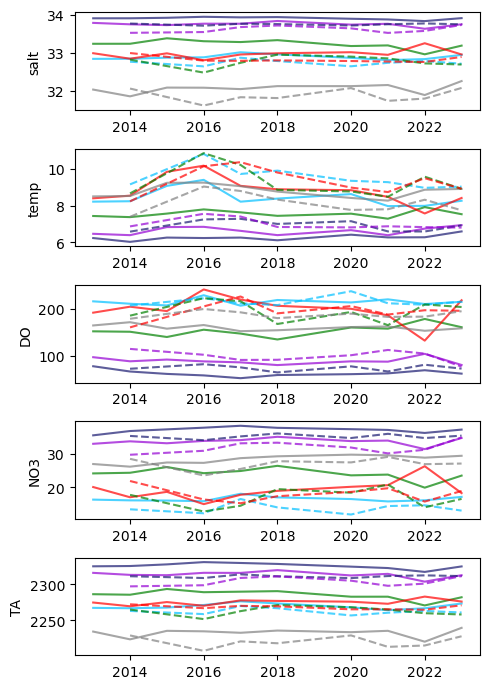

In [8]:
upyears = [2013, 2014, 2015, 2016, 2017, 2018, 2020, 2021, 2022, 2023]
downyears = [2014, 2016, 2017, 2018, 2020, 2021, 2022, 2023]
properties = ['salt','temp','DO','NO3','TA','DIC']

fig, ax = plt.subplots(5,1,figsize=(5,7))

for i in range(len(ax)):
    ax[i].plot(upyears, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.7)
    ax[i].plot(upyears, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.7)
    ax[i].plot(upyears, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7)
    ax[i].plot(upyears, interannual('north', properties[i], 'up'),c='green',alpha=0.7)
    ax[i].plot(upyears, interannual('south', properties[i], 'up'),c='red',alpha=0.7)
    # ax[i].plot(upyears, interannual('fresh', properties[i], 'up'),c='magenta',alpha=0.7)
    ax[i].plot(upyears, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7)
    ax[i].plot(downyears, interannual('cuc', properties[i], 'down'),ls='dashed',c='midnightblue',alpha=0.7)
    ax[i].plot(downyears, interannual('offshore deep', properties[i], 'down'),ls='dashed',c='darkviolet',alpha=0.7)
    ax[i].plot(downyears, interannual('offshore surface', properties[i], 'down'),ls='dashed',c='deepskyblue',alpha=0.7)
    ax[i].plot(downyears, interannual('north', properties[i], 'down'),ls='dashed',c='green',alpha=0.7)
    ax[i].plot(downyears, interannual('south', properties[i], 'down'),ls='dashed',c='red',alpha=0.7)
    # ax[i].plot(downyears, interannual('fresh', properties[i], 'down'),ls='dashed',c='magenta',alpha=0.7)
    ax[i].plot(downyears, interannual('loop', properties[i], 'down'),ls='dashed',c='grey',alpha=0.7)

    ax[i].set_ylabel(properties[i])

plt.tight_layout()

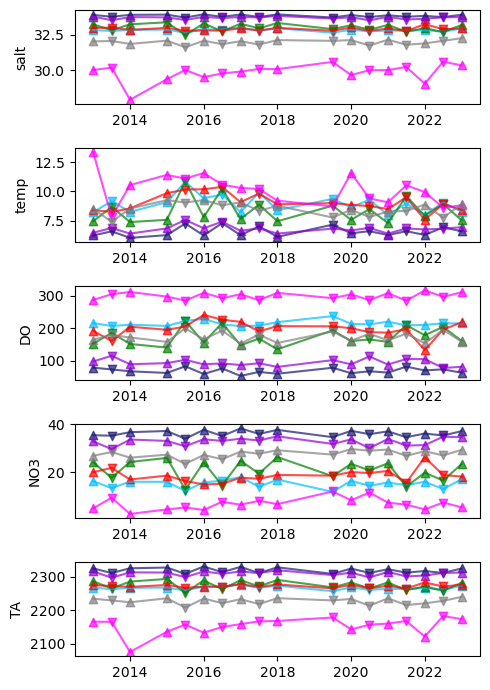

In [9]:
updownyears = np.sort(np.append(np.array(upyears),(np.array(downyears) - 0.5)))
properties = ['salt','temp','DO','NO3','TA','DIC']

fig, ax = plt.subplots(5,1,figsize=(5,7))

for i in range(len(ax)):
    ax[i].scatter(upyears, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('north', properties[i], 'up'),c='green',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('south', properties[i], 'up'),c='red',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('fresh', properties[i], 'up'),c='magenta',alpha=0.7,marker='^')
    ax[i].scatter(upyears, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7,marker='^')

    ax[i].scatter(np.array(downyears) - 0.5, interannual('cuc', properties[i], 'down'),c='midnightblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('offshore deep', properties[i], 'down'),c='darkviolet',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('north', properties[i], 'down'),c='green',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('south', properties[i], 'down'),c='red',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('fresh', properties[i], 'down'),c='magenta',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears) - 0.5, interannual('loop', properties[i], 'down'),c='grey',alpha=0.7,marker='v')

    ax[i].plot(updownyears, interannual('cuc', properties[i], 'both'),c='midnightblue',alpha=0.7)
    ax[i].plot(updownyears, interannual('offshore deep', properties[i], 'both'),c='darkviolet',alpha=0.7)
    ax[i].plot(updownyears, interannual('offshore surface', properties[i], 'both'),c='deepskyblue',alpha=0.7)
    ax[i].plot(updownyears, interannual('north', properties[i], 'both'),c='green',alpha=0.7)
    ax[i].plot(updownyears, interannual('south', properties[i], 'both'),c='red',alpha=0.7)
    ax[i].plot(updownyears, interannual('fresh', properties[i], 'both'),c='magenta',alpha=0.7)
    ax[i].plot(updownyears, interannual('loop', properties[i], 'both'),c='grey',alpha=0.7)

    ax[i].set_ylabel(properties[i])

plt.tight_layout()

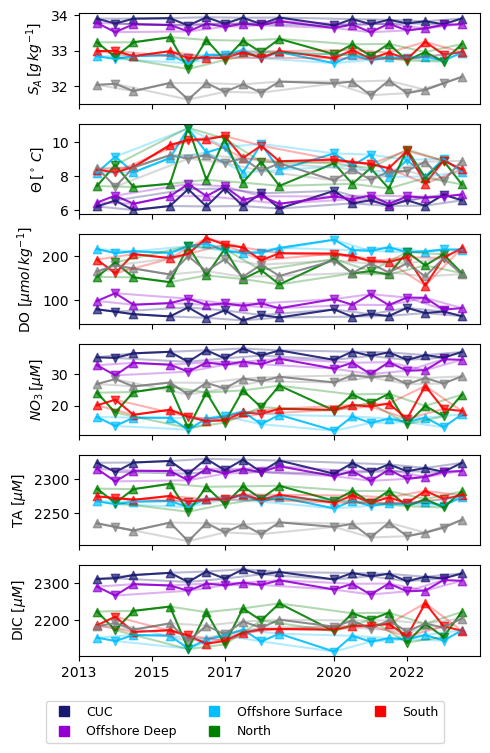

In [10]:
# don't actually keep fresh for final publication... too different from other water masses it makes the y-axis range bad
updownyears = np.sort(np.append(np.array(upyears)+0.5,(np.array(downyears))))
properties = ['salt','temp','DO','NO3','TA','DIC']
prop_names = ['$S_A \,[g\, kg^{-1}]$','$\Theta \,[^\circ \, C]$','DO $[\mu mol \, kg^{-1}]$','$NO_3 \, [\mu M]$','TA $[\mu M]$','DIC $[\mu M]$']

fig, ax = plt.subplots(6,1,figsize=(5,7))

for i in range(len(ax)):

    ax[i].plot(updownyears, interannual('cuc', properties[i], 'both'),c='midnightblue',alpha=0.9)
    ax[i].plot(updownyears, interannual('offshore deep', properties[i], 'both'),c='darkviolet',alpha=0.9)
    ax[i].plot(updownyears, interannual('offshore surface', properties[i], 'both'),c='deepskyblue',alpha=0.9)
    ax[i].plot(updownyears, interannual('north', properties[i], 'both'),c='green',alpha=0.9)
    ax[i].plot(updownyears, interannual('south', properties[i], 'both'),c='red',alpha=0.9)
    ax[i].plot(updownyears, interannual('loop', properties[i], 'both'),c='grey',alpha=0.9)

    ax[i].scatter(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='green',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.7,marker='^')
    ax[i].scatter(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7,marker='^')

    ax[i].scatter(np.array(downyears), interannual('cuc', properties[i], 'down'),c='midnightblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('offshore deep', properties[i], 'down'),c='darkviolet',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('north', properties[i], 'down'),c='green',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('south', properties[i], 'down'),c='red',alpha=0.7,marker='v')
    ax[i].scatter(np.array(downyears), interannual('loop', properties[i], 'down'),c='grey',alpha=0.7,marker='v')

    # very transparrent line jsut for connecting upwelling and downwelling respectively?
    ax[i].plot(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='midnightblue',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='darkviolet',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='green',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.3)
    ax[i].plot(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.3)

    ax[i].plot((np.array(downyears)), interannual('cuc', properties[i], 'down'),c='midnightblue',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('offshore deep', properties[i], 'down'),c='darkviolet',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('north', properties[i], 'down'),c='green',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('south', properties[i], 'down'),c='red',alpha=0.3)
    ax[i].plot((np.array(downyears)), interannual('loop', properties[i], 'down'),c='grey',alpha=0.3)

    ax[i].set_xticks(upyears[::2])
    ax[i].set_xticklabels([])
    ax[i].set_ylabel(prop_names[i])

ax[5].set_xticklabels(upyears[::2])

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South']
colours = ['midnightblue','darkviolet','deepskyblue','green','red']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.0001), frameon=True,fontsize=9)

plt.tight_layout()
# plt.savefig("/data1/bbeutel/LO_user/ariane/figures/modelpropvar.pdf", bbox_inches='tight')

In [39]:
######################
# BOX PLOT FUNCTIONS #
######################
def box(regions,property,updown,ax,**kwargs):
    tracer = [interannual(region, property, updown) for region in regions]

    # Filter data using np.isnan (boxplots can't really handle nans)
    t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

    bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)
    ax.set_xticks([])

    return bplot

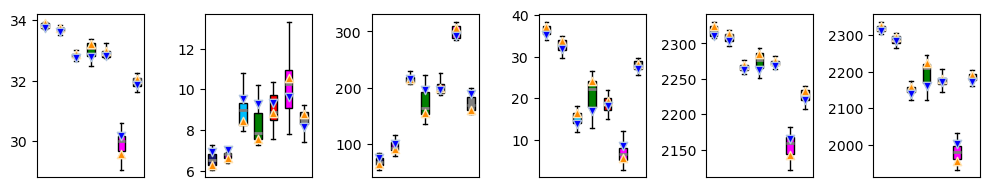

In [40]:
# box plots of the same data
# first using all the already averaged information
colours = ['midnightblue', 'darkviolet', 'deepskyblue', 'green', 'red','magenta','grey']
fig,ax = plt.subplots(1,6,figsize=(10,2))

regions = up13.regions[1:]
for i in range(len(ax)):
    bplot = box(regions,properties[i],'both',ax[i],alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

    upmean =  [np.nanmean(interannual(region, properties[i], 'up')) for region in regions]
    dwmean =  [np.nanmean(interannual(region, properties[i], 'down')) for region in regions]
    ax[i].scatter(np.arange(1,len(regions)+1),upmean,marker='^',c='darkorange',edgecolors='moccasin',zorder=4)
    ax[i].scatter(np.arange(1,len(regions)+1),dwmean, marker='v',c='blue',edgecolors='lightsteelblue',zorder=4)


    # add upwelling and downwelling means

plt.tight_layout()

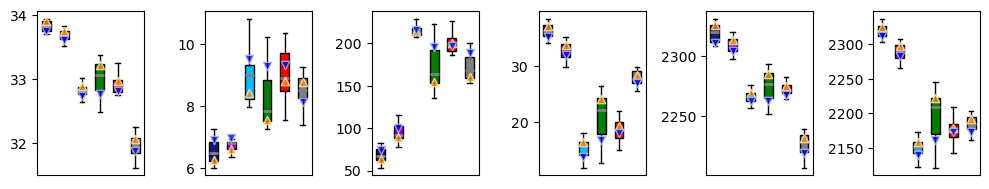

In [13]:
colours = ['midnightblue', 'darkviolet', 'deepskyblue', 'green', 'red','grey']
regions = ['cuc', 'offshore deep', 'offshore surface', 'north', 'south', 'loop']
fig,ax = plt.subplots(1,6,figsize=(10,2))
for i in range(len(ax)):
    bplot = box(regions,properties[i],'both',ax[i],alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)

    upmean =  [np.nanmean(interannual(region, properties[i], 'up')) for region in regions]
    dwmean =  [np.nanmean(interannual(region, properties[i], 'down')) for region in regions]
    ax[i].scatter(np.arange(1,len(regions)+1),upmean,marker='^',c='darkorange',edgecolors='moccasin',zorder=4,alpha=0.8)
    ax[i].scatter(np.arange(1,len(regions)+1),dwmean, marker='v',c='blue',edgecolors='lightsteelblue',zorder=4,alpha=0.8)


    # add upwelling and downwelling means

plt.tight_layout()

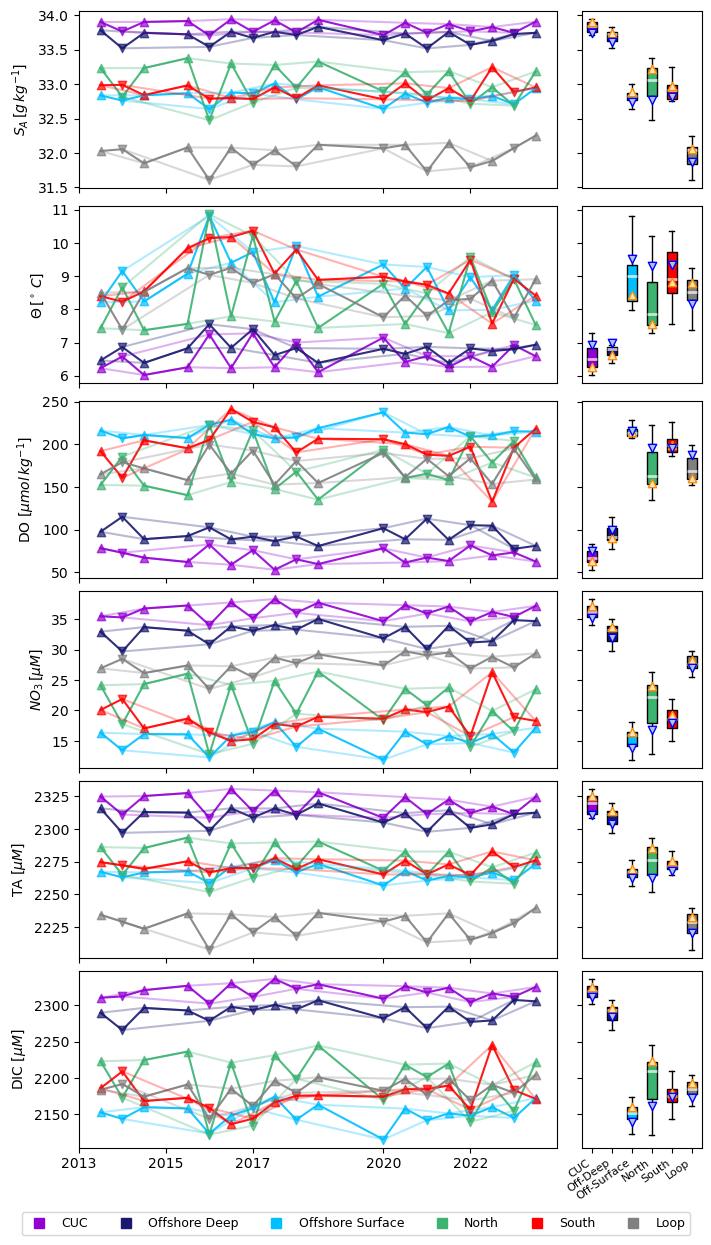

In [41]:
updownyears = np.sort(np.append(np.array(upyears)+0.5,(np.array(downyears))))
properties = ['salt','temp','DO','NO3','TA','DIC']
prop_names = ['$S_A \,[g\, kg^{-1}]$','$\Theta \,[^\circ \, C]$','DO $[\mu mol \, kg^{-1}]$','$NO_3 \, [\mu M]$','TA $[\mu M]$','DIC $[\mu M]$']

fig = plt.figure(constrained_layout=True, figsize=[7,2*6])
gs = GridSpec(6, 5, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])
ax3 = fig.add_subplot(gs[1, :4])
ax4 = fig.add_subplot(gs[1, 4])
ax5 = fig.add_subplot(gs[2, :4])
ax6 = fig.add_subplot(gs[2, 4])
ax7 = fig.add_subplot(gs[3, :4])
ax8 = fig.add_subplot(gs[3, 4])
ax9 = fig.add_subplot(gs[4, :4])
ax10 = fig.add_subplot(gs[4, 4])
ax11 = fig.add_subplot(gs[5, :4])
ax12 = fig.add_subplot(gs[5, 4])

# TIMESERIES
i=0
for ax in [ax1,ax3,ax5,ax7,ax9,ax11]:

    ax.plot(updownyears, interannual('cuc', properties[i], 'both'),c='darkviolet',alpha=0.9)
    ax.plot(updownyears, interannual('offshore deep', properties[i], 'both'),c='midnightblue',alpha=0.9)
    ax.plot(updownyears, interannual('offshore surface', properties[i], 'both'),c='deepskyblue',alpha=0.9)
    ax.plot(updownyears, interannual('north', properties[i], 'both'),c='mediumseagreen',alpha=0.9)
    ax.plot(updownyears, interannual('south', properties[i], 'both'),c='red',alpha=0.9)
    ax.plot(updownyears, interannual('loop', properties[i], 'both'),c='grey',alpha=0.9)

    ax.scatter(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='darkviolet',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='midnightblue',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='mediumseagreen',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.7,marker='^')
    ax.scatter(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.7,marker='^')

    ax.scatter(np.array(downyears), interannual('cuc', properties[i], 'down'),c='darkviolet',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('offshore deep', properties[i], 'down'),c='midnightblue',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('north', properties[i], 'down'),c='mediumseagreen',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('south', properties[i], 'down'),c='red',alpha=0.7,marker='v')
    ax.scatter(np.array(downyears), interannual('loop', properties[i], 'down'),c='grey',alpha=0.7,marker='v')

    # very transparrent line jsut for connecting upwelling and downwelling respectively?
    ax.plot(np.array(upyears)+0.5, interannual('cuc', properties[i], 'up'),c='darkviolet',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('offshore deep', properties[i], 'up'),c='midnightblue',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('offshore surface', properties[i], 'up'),c='deepskyblue',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('north', properties[i], 'up'),c='mediumseagreen',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('south', properties[i], 'up'),c='red',alpha=0.3)
    ax.plot(np.array(upyears)+0.5, interannual('loop', properties[i], 'up'),c='grey',alpha=0.3)

    ax.plot((np.array(downyears)), interannual('cuc', properties[i], 'down'),c='darkviolet',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('offshore deep', properties[i], 'down'),c='midnightblue',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('offshore surface', properties[i], 'down'),c='deepskyblue',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('north', properties[i], 'down'),c='mediumseagreen',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('south', properties[i], 'down'),c='red',alpha=0.3)
    ax.plot((np.array(downyears)), interannual('loop', properties[i], 'down'),c='grey',alpha=0.3)

    ax.set_xticks(upyears[::2])
    ax.set_xticklabels([])
    ax.set_ylabel(prop_names[i])
    i+=1

ax11.set_xticklabels(upyears[::2])

# BOXPLOTS
colours = ['darkviolet', 'midnightblue', 'deepskyblue', 'mediumseagreen', 'red','grey']
regions = ['cuc', 'offshore deep', 'offshore surface', 'north', 'south', 'loop']
i=0
for ax in [ax2,ax4,ax6,ax8,ax10,ax12]:
    bplot = box(regions,properties[i],'both',ax,alpha=0.5)
    for patch, color in zip(bplot['boxes'], colours):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_alpha(0.7)
        median.set_linewidth(2)

    upmean =  [np.nanmean(interannual(region, properties[i], 'up')) for region in regions]
    dwmean =  [np.nanmean(interannual(region, properties[i], 'down')) for region in regions]
    ax.scatter(np.arange(1,len(regions)+1),upmean,marker='^',c='moccasin',edgecolors='darkorange',zorder=4)
    ax.scatter(np.arange(1,len(regions)+1),dwmean, marker='v',c='lightsteelblue',edgecolors='blue',zorder=4)
    ax.set_yticks([])
    i+=1
ax12.set_xticks(np.arange(1,len(regions)+1))
ax12.set_xticklabels(['CUC', 'Off-Deep', 'Off-Surface', 'North', 'South','Loop'],rotation=35,ha='right',fontsize=8)

# ensure that the box plots share the same yaxis as the timeseries plots
ax2.sharey(ax1)
ax2.tick_params(axis='y', which='both', labelleft=False)
ax4.sharey(ax3)
ax4.tick_params(axis='y', which='both', labelleft=False)
ax6.sharey(ax5)
ax6.tick_params(axis='y', which='both', labelleft=False)
ax8.sharey(ax7)
ax8.tick_params(axis='y', which='both', labelleft=False)
ax10.sharey(ax9)
ax10.tick_params(axis='y', which='both', labelleft=False)
ax12.sharey(ax11)
ax12.tick_params(axis='y', which='both', labelleft=False)

# # build legend handles    
legend_handles = []
regionnames = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South','Loop']
colours = ['darkviolet','midnightblue','deepskyblue','mediumseagreen','red','grey']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regionnames[i]))
# Add a figure-wide legend below the subplots
fig.legend(handles=legend_handles, loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.0001), frameon=True,fontsize=9)

plt.savefig("/data1/bbeutel/LO_user/ariane/figures/modelpropvar.pdf", bbox_inches='tight')

In [22]:
prop='salt'
d = {'cuc': interannual('cuc', prop, 'both'),
         'offshore deep': interannual('offshore deep', prop, 'both'),
         'offshore surface':interannual('offshore surface', prop, 'both'),
         'north':interannual('north', prop, 'both'),
         'south':interannual('south', prop, 'both'),
         'loop':interannual('loop', prop, 'both'),
         'fresh':interannual('fresh', prop, 'both'),}
mydata = pd.DataFrame(d)

np.mean(mydata['cuc']) - np.mean(mydata['north'])

0.8117860232202787

In [23]:
# statistics of combined periods
alpha = 0.05

for prop in properties:
    print(prop)
    
    # Prepare data
    d = {'cuc': interannual('cuc', prop, 'both'),
         'offshore deep': interannual('offshore deep', prop, 'both'),
         'offshore surface': interannual('offshore surface', prop, 'both'),
         'north': interannual('north', prop, 'both'),
         'south': interannual('south', prop, 'both'),
         'loop': interannual('loop', prop, 'both'),
         'fresh': interannual('fresh', prop, 'both')}
    
    mydata = pd.DataFrame(d)
    
    # Perform one-way ANOVA
    groups = [mydata[region] for region in mydata.columns]
    anova_result = stats.f_oneway(*groups)
    
    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Flatten data for Tukey test
        flattened_data = mydata.melt(var_name='region', value_name='value').dropna()
        endog = flattened_data['value']
        group_labels = flattened_data['region']
        
        # Perform Tukey HSD test
        tukey_result = pairwise_tukeyhsd(endog=endog, groups=group_labels, alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d for each pair of regions
        additional_results = []
        for _, row in tukey_df.iterrows():
            region1 = row['group1']
            region2 = row['group2']
            data1 = mydata[region1].dropna()
            data2 = mydata[region2].dropna()
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            additional_results.append(cohens_d)
        
        # Add Cohen's d to the DataFrame
        tukey_df['Cohen\'s d'] = additional_results
        print("Tukey HSD post hoc results with Cohen's d:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')


salt
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d:
              group1            group2  meandiff  reject  Cohen's d
0                cuc             fresh   -3.9887    True   8.952650
1                cuc              loop   -1.8569    True  13.672944
2                cuc             north   -0.8118    True   4.086563
3                cuc     offshore deep   -0.1449   False   1.594247
4                cuc  offshore surface   -1.0143    True  10.879222
5                cuc             south   -0.9304    True   8.607065
6              fresh              loop    2.1318    True  -4.656432
7              fresh             north    3.1770    True  -6.615538
8              fresh     offshore deep    3.8439    True  -8.607680
9              fresh  offshore surface    2.9745    True  -6.653640
10             fresh             south    3.0583    True  -6.790522
11              loop             north    1.0451    True  -4.64

In [24]:
# statistics of upwelling
alpha = 0.05

for prop in properties:
    print(prop)
    
    # Prepare data
    d = {'cuc': interannual('cuc', prop, 'up'),
         'offshore deep': interannual('offshore deep', prop, 'up'),
         'offshore surface': interannual('offshore surface', prop, 'up'),
         'north': interannual('north', prop, 'up'),
         'south': interannual('south', prop, 'up'),
         'loop': interannual('loop', prop, 'up'),
         'fresh': interannual('fresh', prop, 'up')}
    
    mydata = pd.DataFrame(d)
    
    # Perform one-way ANOVA
    groups = [mydata[region] for region in mydata.columns]
    anova_result = stats.f_oneway(*groups)
    
    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Flatten data for Tukey test
        flattened_data = mydata.melt(var_name='region', value_name='value').dropna()
        endog = flattened_data['value']
        group_labels = flattened_data['region']
        
        # Perform Tukey HSD test
        tukey_result = pairwise_tukeyhsd(endog=endog, groups=group_labels, alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d for each pair of regions
        additional_results = []
        for _, row in tukey_df.iterrows():
            region1 = row['group1']
            region2 = row['group2']
            data1 = mydata[region1].dropna()
            data2 = mydata[region2].dropna()
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            additional_results.append(cohens_d)
        
        # Add Cohen's d to the DataFrame
        tukey_df['Cohen\'s d'] = additional_results
        print("Tukey HSD post hoc results with Cohen's d:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')


salt
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d:
              group1            group2  meandiff  reject  Cohen's d
0                cuc             fresh   -4.3262    True   8.707694
1                cuc              loop   -1.8428    True  21.018224
2                cuc             north   -0.6775    True   7.958109
3                cuc     offshore deep   -0.1556   False   3.579169
4                cuc  offshore surface   -1.0209    True  19.687025
5                cuc             south   -0.9337    True  10.733933
6              fresh              loop    2.4833    True  -4.933043
7              fresh             north    3.6487    True  -7.254337
8              fresh     offshore deep    4.1706    True  -8.381123
9              fresh  offshore surface    3.3053    True  -6.631540
10             fresh             south    3.3925    True  -6.740671
11              loop             north    1.1654    True  -9.90

In [25]:
# statistics of downwelling
alpha = 0.05

for prop in properties:
    print(prop)
    
    # Prepare data
    d = {'cuc': interannual('cuc', prop, 'down'),
         'offshore deep': interannual('offshore deep', prop, 'down'),
         'offshore surface': interannual('offshore surface', prop, 'down'),
         'north': interannual('north', prop, 'down'),
         'south': interannual('south', prop, 'down'),
         'loop': interannual('loop', prop, 'down'),
         'fresh': interannual('fresh', prop, 'down')}
    
    mydata = pd.DataFrame(d)
    
    # Perform one-way ANOVA
    groups = [mydata[region] for region in mydata.columns]
    anova_result = stats.f_oneway(*groups)
    
    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Flatten data for Tukey test
        flattened_data = mydata.melt(var_name='region', value_name='value').dropna()
        endog = flattened_data['value']
        group_labels = flattened_data['region']
        
        # Perform Tukey HSD test
        tukey_result = pairwise_tukeyhsd(endog=endog, groups=group_labels, alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0]).drop(['p-adj','lower','upper'],axis=1)
        
        # Calculate Cohen's d for each pair of regions
        additional_results = []
        for _, row in tukey_df.iterrows():
            region1 = row['group1']
            region2 = row['group2']
            data1 = mydata[region1].dropna()
            data2 = mydata[region2].dropna()
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            additional_results.append(cohens_d)
        
        # Add Cohen's d to the DataFrame
        tukey_df['Cohen\'s d'] = additional_results
        print("Tukey HSD post hoc results with Cohen's d:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')


salt
Significant differences found between regions (p = 0.0000) at α = 0.05.

Tukey HSD post hoc results with Cohen's d:
              group1            group2  meandiff  reject  Cohen's d
0                cuc             fresh   -3.5669    True  17.375278
1                cuc              loop   -1.8745    True  15.068239
2                cuc             north   -0.9797    True   9.260484
3                cuc     offshore deep   -0.1315   False   2.095978
4                cuc  offshore surface   -1.0060    True  17.924825
5                cuc             south   -0.9264    True  15.790650
6              fresh              loop    1.6924    True  -7.081493
7              fresh             north    2.5872    True -11.256049
8              fresh     offshore deep    3.4354    True -16.091690
9              fresh  offshore surface    2.5609    True -12.100635
10             fresh             south    2.6406    True -12.436485
11              loop             north    0.8948    True  -5.53

In [26]:
# salt
property = 'salt'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


salt
cuc
UP: mean =33.90278570089663, std =0.0314429059466788, CV = 0.0009274431376843238
DOWN: mean =33.74440024249207, std =0.02098396731126485, CV = 0.0006218503562212121
UP & DOWN: mean =33.83239216382793, std =0.08330076189797996, CV = 0.002462159976587212


offshore deep
UP: mean =33.74720410232633, std =0.049117048681323786, CV = 0.0014554405316776437
DOWN: mean =33.61287240185578, std =0.08031783956241338, CV = 0.0023894964584454553
UP & DOWN: mean =33.687501124339434, std =0.0930747946214323, CV = 0.0027628880598147177


offshore surface
UP: mean =32.88190097063452, std =0.06206102337732311, CV = 0.001887391590673157
DOWN: mean =32.7383938538277, std =0.07121750428530864, CV = 0.0021753511978408204
UP & DOWN: mean =32.81812002983149, std =0.0973599731746181, CV = 0.002966652967510583


north
UP: mean =33.22533296772585, std =0.1097968239025884, CV = 0.0033046116952158743
DOWN: mean =32.764697606709895, std =0.13837008901336637, CV = 0.004223145614657817
UP & DOWN: mean =33.020

In [27]:
# temp
property = 'temp'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


temp
cuc
UP: mean =6.26222861031003, std =0.14632178386004507, CV = 0.023365768477238806
DOWN: mean =6.917374677103625, std =0.28032243542095886, CV = 0.040524396683155044
UP & DOWN: mean =6.5534046399960735, std =0.39089457890107027, CV = 0.05964755731935156


offshore deep
UP: mean =6.623511448662006, std =0.19910861403171307, CV = 0.030060884709716077
DOWN: mean =6.993561519454834, std =0.2818482578331836, CV = 0.0403011051020474
UP & DOWN: mean =6.7879781467921525, std =0.3018976149317229, CV = 0.04447533689754039


offshore surface
UP: mean =8.43604366419198, std =0.4437324645118679, CV = 0.052599593147597754
DOWN: mean =9.528159296555312, std =0.5736111192985925, CV = 0.060201671849248836
UP & DOWN: mean =8.921428389686795, std =0.7417016918439185, CV = 0.0831371008594687


north
UP: mean =7.550460918943512, std =0.1812103935719842, CV = 0.023999911464655303
DOWN: mean =9.2908287605347, std =0.7955177109013709, CV = 0.08562397730120126
UP & DOWN: mean =8.323957737428483, std =1.0

In [28]:
# DO
property = 'DO'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


DO
cuc
UP: mean =63.78545113438213, std =6.525126857167891, CV = 0.1022980435369323
DOWN: mean =74.77349325237586, std =5.84492122937662, CV = 0.07816835853380306
UP & DOWN: mean =68.66902540904601, std =8.285485423336707, CV = 0.12065826439186991


offshore deep
UP: mean =89.88767854104637, std =6.795474687902359, CV = 0.07559962386612608
DOWN: mean =100.00374700925647, std =11.564504087754127, CV = 0.1156407078095154
UP & DOWN: mean =94.38370897136197, std =10.50531166544641, CV = 0.11130428947896025


offshore surface
UP: mean =214.95541164847015, std =6.358975633698668, CV = 0.02958276595565732
DOWN: mean =215.5351515752675, std =9.573541033000327, CV = 0.04441753914862991
UP & DOWN: mean =215.21307383815784, std =7.955015835496289, CV = 0.036963441363597326


north
UP: mean =154.28533922111507, std =11.459076169348121, CV = 0.0742719705397638
DOWN: mean =195.7781188751745, std =19.996866747891406, CV = 0.10214045810012681
UP & DOWN: mean =172.72657462291926, std =25.99560099022059

In [29]:
# NO3
property = 'NO3'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


NO3
cuc
UP: mean =37.10725589244983, std =0.7710474540240894, CV = 0.02077888637895678
DOWN: mean =35.149674879897745, std =0.6316442862921455, CV = 0.01797013168543945
UP & DOWN: mean =36.237219886871124, std =1.205740838341256, CV = 0.033273546980299676


offshore deep
UP: mean =33.64317034956511, std =0.9616337961455929, CV = 0.028583328686145163
DOWN: mean =31.8711238144045, std =1.6474000194008458, CV = 0.05168942359843256
UP & DOWN: mean =32.85559411171595, std =1.5796453118909572, CV = 0.04807842787806028


offshore surface
UP: mean =16.51201275869918, std =0.6750737134182795, CV = 0.040883793107695125
DOWN: mean =13.79638197532482, std =1.374942166837609, CV = 0.09965961868095041
UP & DOWN: mean =15.305065743866132, std =1.7071288039097883, CV = 0.11154011570279994


north
UP: mean =24.07580859987663, std =1.6752373053021268, CV = 0.06958176704024434
DOWN: mean =16.80564146569327, std =2.6421326623714108, CV = 0.15721700762003119
UP & DOWN: mean =20.84462320690625, std =4.20861

In [30]:
# TA
property = 'TA'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


TA
cuc
UP: mean =2325.281865530823, std =3.6832000383952956, CV = 0.0015839800296874903
DOWN: mean =2310.8374009146874, std =1.623348439438717, CV = 0.0007024935803774662
UP & DOWN: mean =2318.8621034792077, std =7.760448027088979, CV = 0.0033466621475443698


offshore deep
UP: mean =2313.346703639161, std =3.9366294356608464, CV = 0.0017017031772488206
DOWN: mean =2303.6206302432824, std =5.564295684948523, CV = 0.0024154566129063037
UP & DOWN: mean =2309.0240043521035, std =6.762192733770067, CV = 0.0029285935187440774


offshore surface
UP: mean =2269.34886736948, std =3.668329199072241, CV = 0.0016164677242086587
DOWN: mean =2262.3040737289884, std =3.9858066155469354, CV = 0.0017618350520746191
UP & DOWN: mean =2266.217847973706, std =5.175978068689872, CV = 0.0022839719814747163


north
UP: mean =2285.0891866285997, std =6.038489826250164, CV = 0.0026425619890833663
DOWN: mean =2262.5803273730853, std =5.720892792552629, CV = 0.002528481629288598
UP & DOWN: mean =2275.08524918170

In [31]:
# DIC
property = 'DIC'
print(property)
for region in regions:
    print(region)
    x = interannual(region, property, 'up')
    print("UP: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'down')
    print("DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    x = interannual(region, property, 'both')
    print("UP & DOWN: mean ={}, std ={}, CV = {}".format(np.nanmean(x),np.nanstd(x),np.nanstd(x)/np.nanmean(x)))
    print('\n')


DIC
cuc
UP: mean =2324.528079038654, std =6.994124141994004, CV = 0.003008836161224835
DOWN: mean =2311.371954162272, std =6.179705607674488, CV = 0.002673609323910935
UP & DOWN: mean =2318.680912426929, std =9.321267073755784, CV = 0.004020073233793671


offshore deep
UP: mean =2296.3703558847633, std =7.563060744593671, CV = 0.0032934847487524357
DOWN: mean =2283.3403799398375, std =13.167388391258122, CV = 0.005766721644718193
UP & DOWN: mean =2290.5792554647965, std =12.27829794190227, CV = 0.005360346258532233


offshore surface
UP: mean =2159.512903746997, std =7.991895848361635, CV = 0.0037007863368145656
DOWN: mean =2139.5744212051313, std =12.923395303877314, CV = 0.0060401709684854595
UP & DOWN: mean =2150.651355950612, std =14.417726978877202, CV = 0.006703888540085756


north
UP: mean =2222.9547197112324, std =13.572407581872673, CV = 0.006105570869943659
DOWN: mean =2161.522995922537, std =27.370666717453894, CV = 0.0126626766261962
UP & DOWN: mean =2195.6517313607014, std